# Market Basket Analysis for Multi-Store Retail Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import ast
import networkx as nx

# Set display options
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = [12, 8]

# Load the dataset
# Assuming data is in a CSV file
df = pd.read_csv('../data/sample-2/processed/transaction_baskets.csv')

# Display first few rows
print("Original data sample:")
display(df.head())

# Check basic information
print("\nDataset info:")
print(df.info())

Original data sample:


,StoreID,TransactionID,ProductID,ProductName,ProductCategory
0,1,10000,['P105'],['Product P105'],['Electronics']
1,1,10001,"['P147', 'P132', 'P110']","['Product P147', 'Product P132', 'Product P110']","['Grocery', 'Electronics', 'Books']"
2,1,10002,"['P130', 'P107', 'P109']","['Product P130', 'Product P107', 'Product P109']","['Electronics', 'Electronics', 'Books']"
3,1,10003,"['P140', 'P144', 'P143', 'P144', 'P138', 'P112...","['Product P140', 'Product P144', 'Product P143...","['Grocery', 'Grocery', 'Books', 'Grocery', 'Ho..."
4,1,10004,"['P131', 'P100', 'P104', 'P114', 'P117']","['Product P131', 'Product P100', 'Product P104...","['Grocery', 'Grocery', 'Apparel', 'Apparel', '..."



Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15096 entries, 0 to 15095
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   StoreID          15096 non-null  int64 
 1   TransactionID    15096 non-null  int64 
 2   ProductID        15096 non-null  object
 3   ProductName      15096 non-null  object
 4   ProductCategory  15096 non-null  object
dtypes: int64(2), object(3)
memory usage: 589.8+ KB
None


## Preprocessing

In [2]:
# Convert string representations of lists to actual lists if needed
def convert_to_list(x):
    if isinstance(x, str):
        return ast.literal_eval(x)
    return x

df['ProductID'] = df['ProductID'].apply(convert_to_list)
df['ProductName'] = df['ProductName'].apply(convert_to_list)
df['ProductCategory'] = df['ProductCategory'].apply(convert_to_list)

# Check data after conversion
print("\nAfter conversion:")
display(df.head())

# Basic statistics
print(f"\nTotal stores: {df['StoreID'].nunique()}")
print(f"Total transactions: {df['TransactionID'].nunique()}")

# Count transactions per store
store_transactions = df.groupby('StoreID').size()
print("\nTransactions per store:")
print(store_transactions)


After conversion:


,StoreID,TransactionID,ProductID,ProductName,ProductCategory
0,1,10000,[P105],[Product P105],[Electronics]
1,1,10001,"[P147, P132, P110]","[Product P147, Product P132, Product P110]","[Grocery, Electronics, Books]"
2,1,10002,"[P130, P107, P109]","[Product P130, Product P107, Product P109]","[Electronics, Electronics, Books]"
3,1,10003,"[P140, P144, P143, P144, P138, P112, P123, P122]","[Product P140, Product P144, Product P143, Pro...","[Grocery, Grocery, Books, Grocery, Home Goods,..."
4,1,10004,"[P131, P100, P104, P114, P117]","[Product P131, Product P100, Product P104, Pro...","[Grocery, Grocery, Apparel, Apparel, Electronics]"



Total stores: 8
Total transactions: 15096

Transactions per store:
StoreID
1    1544
2    2267
3    2092
4    1894
5    1807
6    2010
7    1790
8    1692
dtype: int64


## Exploration

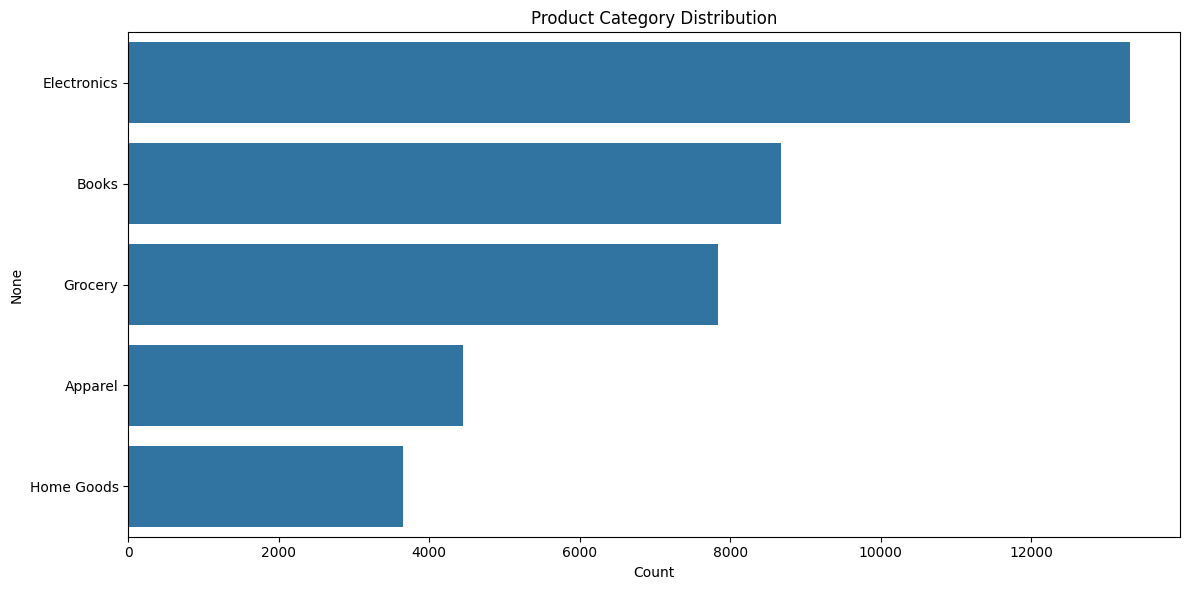

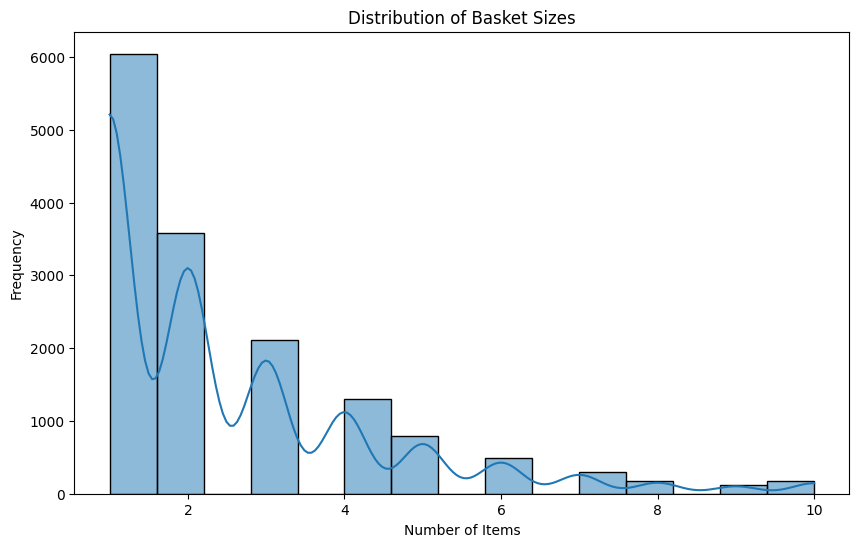

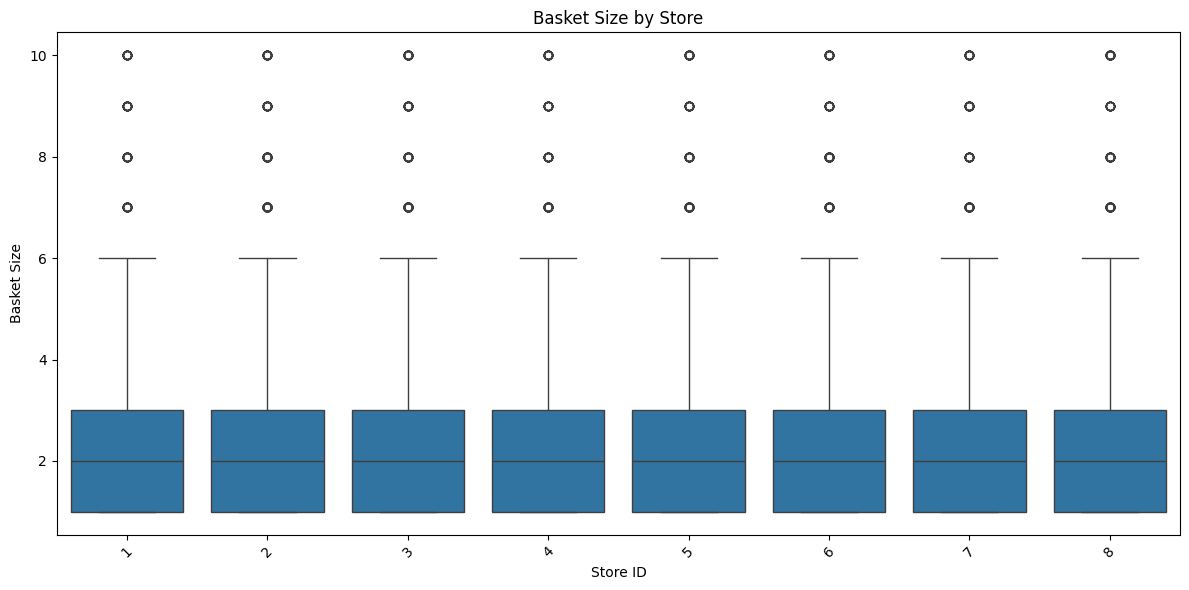

In [3]:
# Analyze product categories across stores
all_categories = []
for categories in df['ProductCategory']:
    all_categories.extend(categories)

category_counts = pd.Series(all_categories).value_counts()

# Plot category distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=category_counts.values, y=category_counts.index)
plt.title('Product Category Distribution')
plt.xlabel('Count')
plt.tight_layout()
plt.savefig('../images/product_category_distribution.png')

# Analyze basket sizes
df['BasketSize'] = df['ProductID'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(df['BasketSize'], bins=15, kde=True)
plt.title('Distribution of Basket Sizes')
plt.xlabel('Number of Items')
plt.ylabel('Frequency')

# Compare basket sizes across stores
plt.figure(figsize=(12, 6))
sns.boxplot(x='StoreID', y='BasketSize', data=df)
plt.title('Basket Size by Store')
plt.xlabel('Store ID')
plt.ylabel('Basket Size')
plt.xticks(rotation=45)
plt.tight_layout()  


## Prepare Data for Market Basket Analysis

In [4]:
# Function to prepare data for a specific store
def prepare_store_data(store_id):
    # Filter data for the specific store
    store_data = df[df['StoreID'] == store_id]
    
    # Create transactions list using product names
    transactions = store_data['ProductName'].tolist()
    
    # Convert transactions to one-hot encoded format
    te = TransactionEncoder()
    te_ary = te.fit(transactions).transform(transactions)
    df_encoded = pd.DataFrame(te_ary, columns=te.columns_)
    
    return store_data, transactions, df_encoded

# Prepare data for all stores
store_data_dict = {}
for store_id in df['StoreID'].unique():
    store_data, transactions, df_encoded = prepare_store_data(store_id)
    store_data_dict[store_id] = {
        'data': store_data,
        'transactions': transactions,
        'encoded': df_encoded
    }
    
    print(f"Store {store_id}: {len(transactions)} transactions prepared")

Store 1: 1544 transactions prepared
Store 2: 2267 transactions prepared
Store 3: 2092 transactions prepared
Store 4: 1894 transactions prepared
Store 5: 1807 transactions prepared
Store 6: 2010 transactions prepared
Store 7: 1790 transactions prepared
Store 8: 1692 transactions prepared


## Apply Apriori Algorithm and Generate Association Rules

In [5]:
# Function to perform market basket analysis
def run_mba(df_encoded, min_support=0.01, min_threshold=1.0):
    # Apply Apriori algorithm
    frequent_itemsets = apriori(df_encoded, min_support=min_support, use_colnames=True)
    
    # Add length of itemsets
    if not frequent_itemsets.empty:
        frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
        frequent_itemsets = frequent_itemsets.sort_values('support', ascending=False)
        
        # Generate association rules
        rules = association_rules(frequent_itemsets, metric="lift", min_threshold=min_threshold)
        
        # Sort rules by lift
        if not rules.empty:
            rules = rules.sort_values('lift', ascending=False)
        
        return frequent_itemsets, rules
    
    return frequent_itemsets, pd.DataFrame()

# Run analysis for each store
results = {}
for store_id, data in store_data_dict.items():
    print(f"\nAnalyzing Store {store_id}...")
    
    # Adjust min_support based on number of transactions
    transactions_count = len(data['transactions'])
    min_support = max(2 / transactions_count, 0.01)  # At least 2 transactions or 1%
    
    frequent_itemsets, rules = run_mba(data['encoded'], min_support=min_support)
    
    results[store_id] = {
        'frequent_itemsets': frequent_itemsets,
        'rules': rules
    }
    
    print(f"Found {len(frequent_itemsets)} frequent itemsets with min_support={min_support:.4f}")
    print(f"Generated {len(rules)} association rules")


Analyzing Store 1...
Found 61 frequent itemsets with min_support=0.0100
Generated 32 association rules

Analyzing Store 2...
Found 56 frequent itemsets with min_support=0.0100
Generated 22 association rules

Analyzing Store 3...
Found 57 frequent itemsets with min_support=0.0100
Generated 24 association rules

Analyzing Store 4...
Found 50 frequent itemsets with min_support=0.0100
Generated 10 association rules

Analyzing Store 5...
Found 54 frequent itemsets with min_support=0.0100
Generated 18 association rules

Analyzing Store 6...
Found 54 frequent itemsets with min_support=0.0100
Generated 18 association rules

Analyzing Store 7...
Found 75 frequent itemsets with min_support=0.0100
Generated 58 association rules

Analyzing Store 8...
Found 68 frequent itemsets with min_support=0.0100
Generated 46 association rules


## Visualize and Interpret Results


Top 10 Association Rules for Store 1:
   If customer buys They also buy   Support  Confidence      Lift
0      Product P144  Product P103  0.014249    0.146667  1.952184
1      Product P103  Product P144  0.014249    0.189655  1.952184
3      Product P108  Product P144  0.014249    0.171875  1.769167
2      Product P144  Product P108  0.014249    0.146667  1.769167
6      Product P103  Product P149  0.012306    0.163793  1.674812
7      Product P149  Product P103  0.012306    0.125828  1.674812
5      Product P106  Product P149  0.012953    0.151515  1.549268
4      Product P149  Product P106  0.012953    0.132450  1.549268
20     Product P108  Product P106  0.010363    0.125000  1.462121
21     Product P106  Product P108  0.010363    0.121212  1.462121


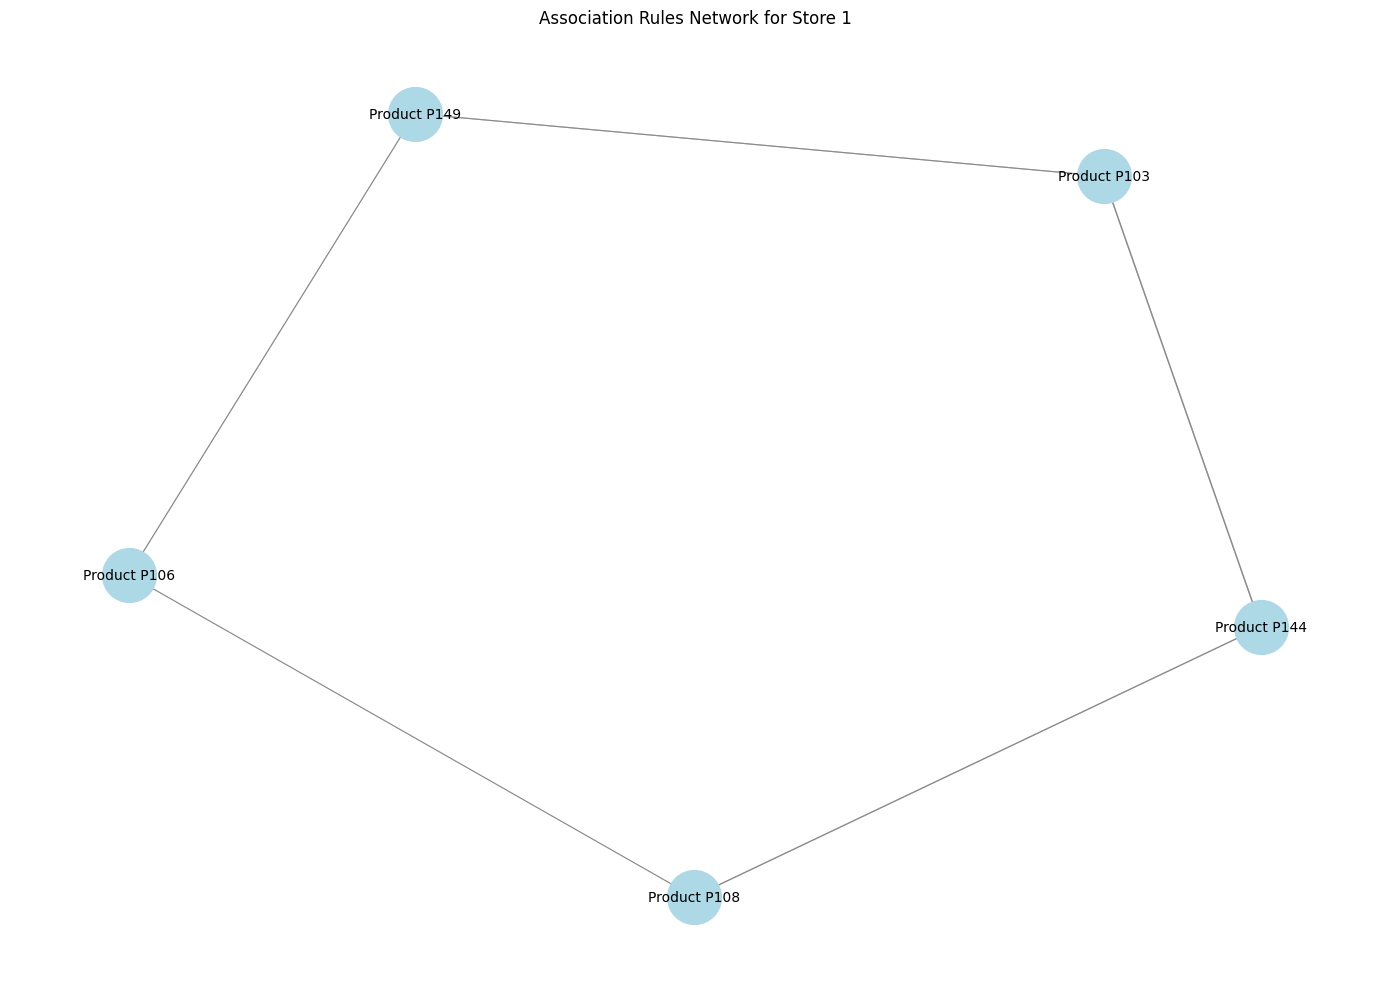

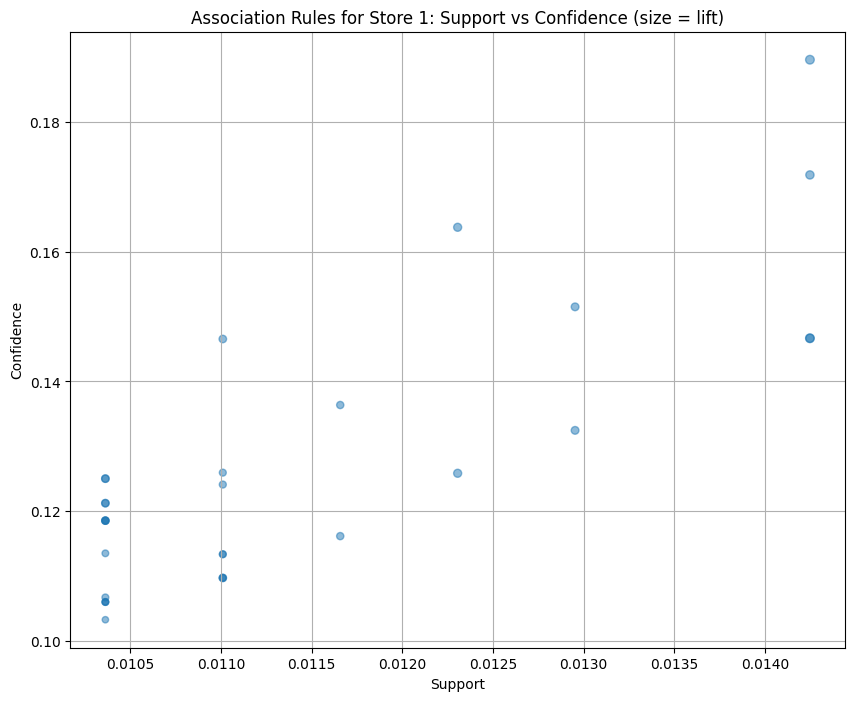


Top 10 Association Rules for Store 2:
   If customer buys They also buy   Support  Confidence      Lift
11     Product P125  Product P149  0.010587    0.172662  2.007305
10     Product P149  Product P125  0.010587    0.123077  2.007305
19     Product P106  Product P115  0.010146    0.113300  1.888619
18     Product P115  Product P106  0.010146    0.169118  1.888619
13     Product P149  Product P127  0.010587    0.123077  1.508191
12     Product P127  Product P149  0.010587    0.129730  1.508191
1      Product P106  Product P105  0.011910    0.133005  1.478050
0      Product P105  Product P106  0.011910    0.132353  1.478050
7      Product P127  Product P105  0.010587    0.129730  1.441653
6      Product P105  Product P127  0.010587    0.117647  1.441653


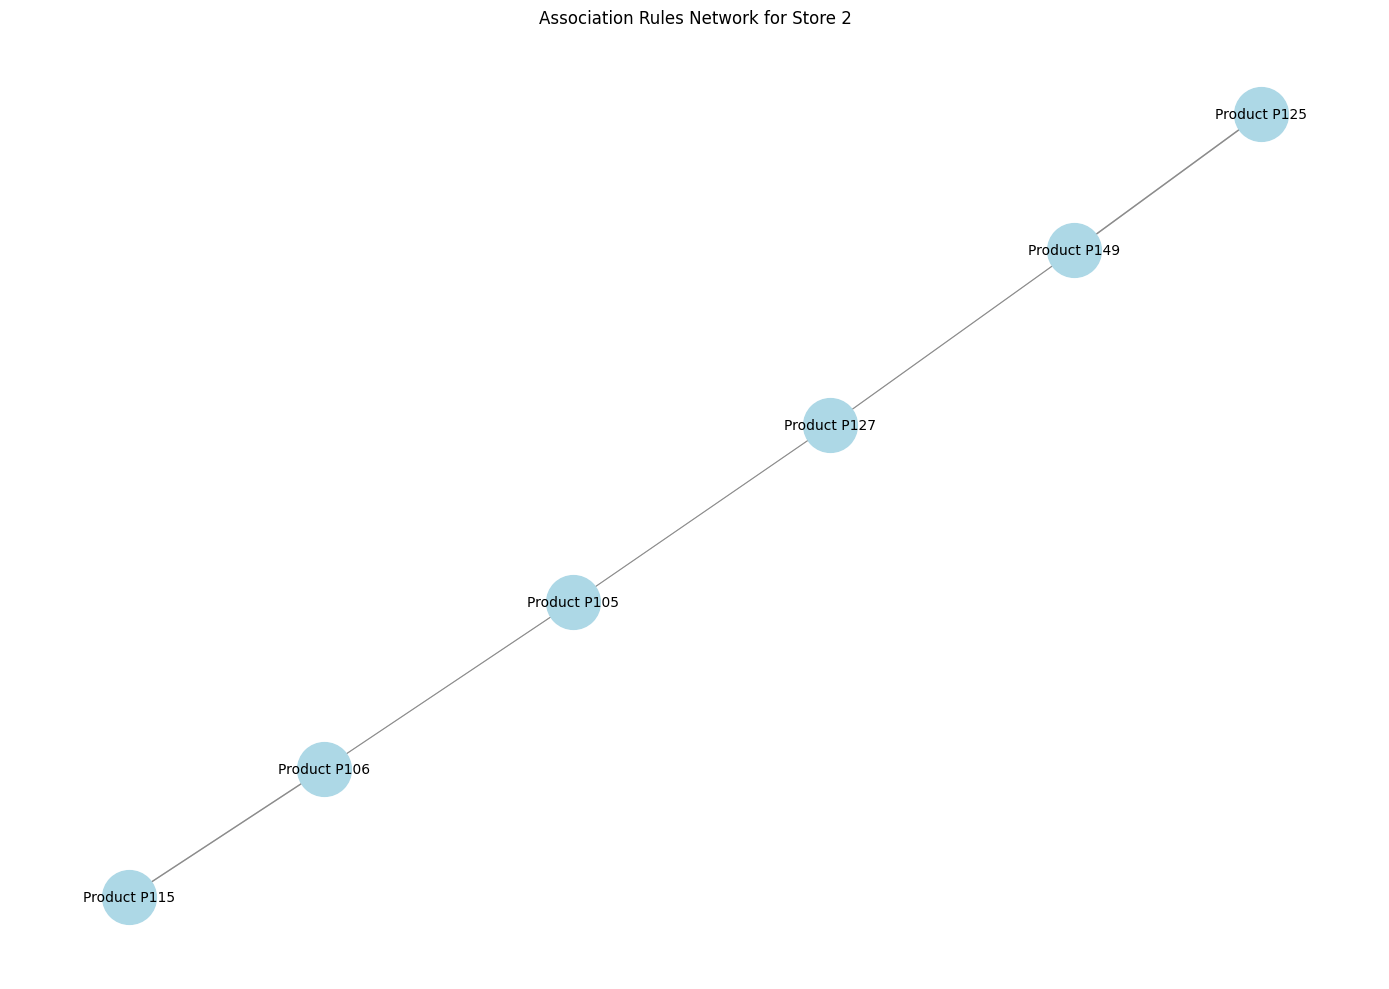

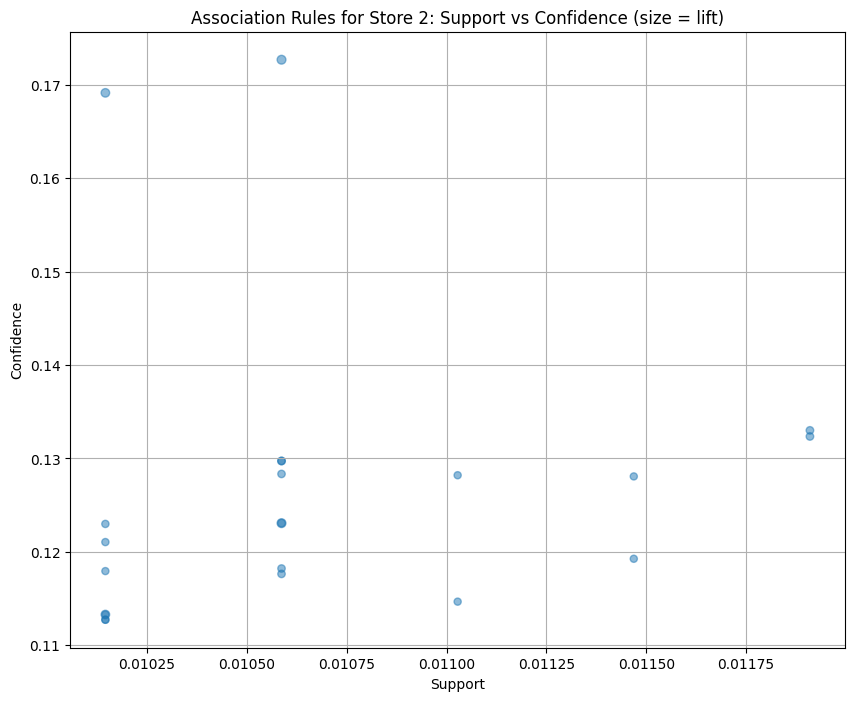


Top 10 Association Rules for Store 3:
   If customer buys They also buy   Support  Confidence      Lift
7      Product P138  Product P127  0.011472    0.181818  2.185998
6      Product P127  Product P138  0.011472    0.137931  2.185998
23     Product P119  Product P127  0.010038    0.161538  1.942175
22     Product P127  Product P119  0.010038    0.120690  1.942175
10     Product P115  Product P147  0.010994    0.160839  1.789763
11     Product P147  Product P115  0.010994    0.122340  1.789763
2      Product P105  Product P122  0.012906    0.132353  1.709150
3      Product P122  Product P105  0.012906    0.166667  1.709150
1      Product P106  Product P132  0.013384    0.153846  1.625486
0      Product P132  Product P106  0.013384    0.141414  1.625486


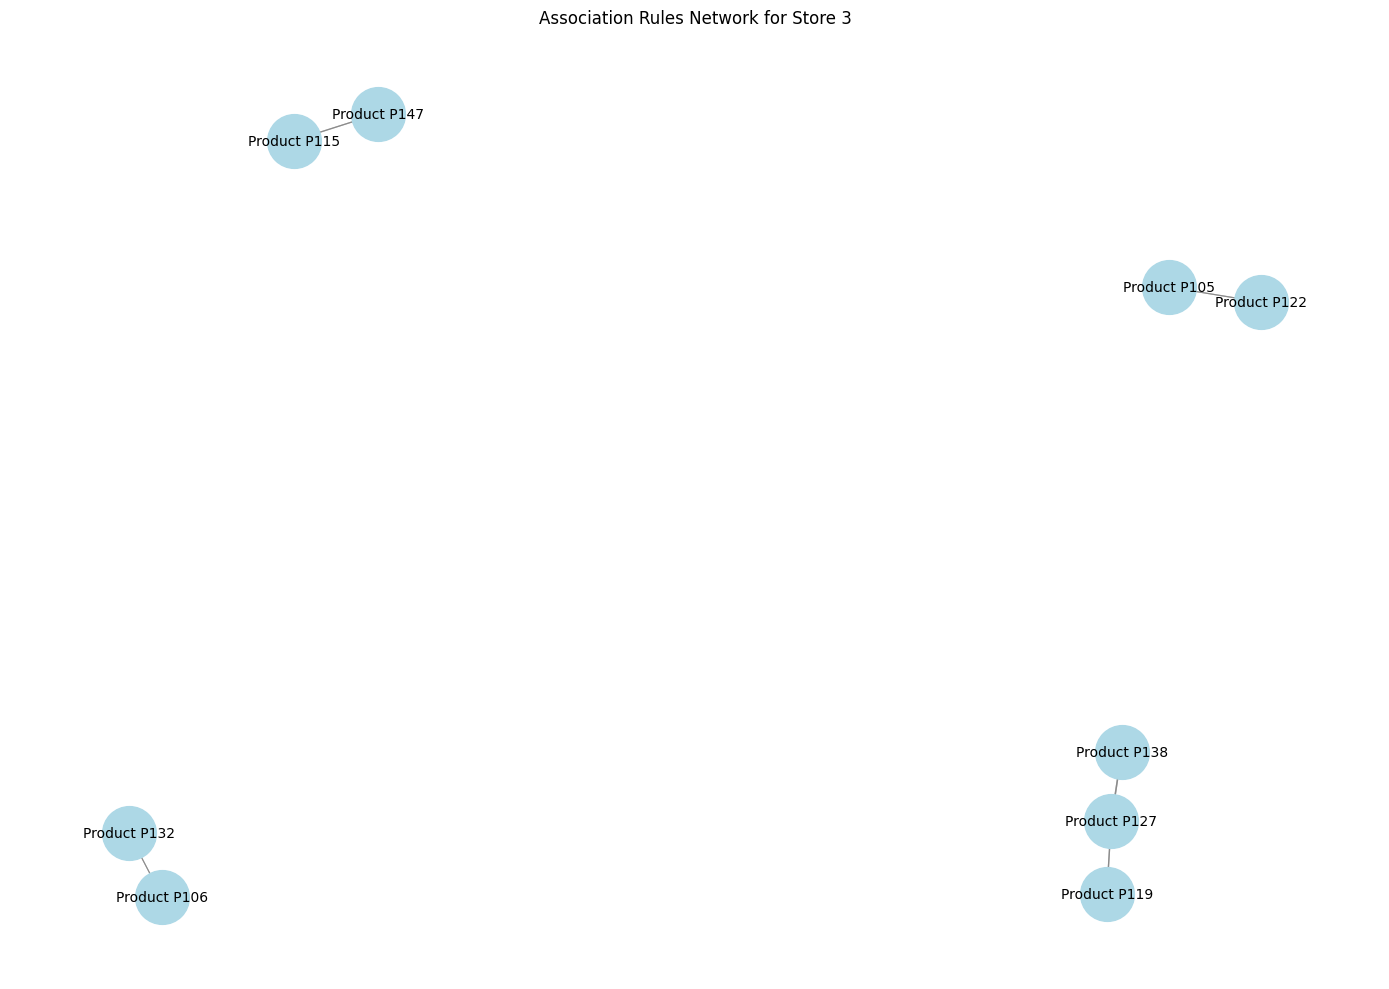

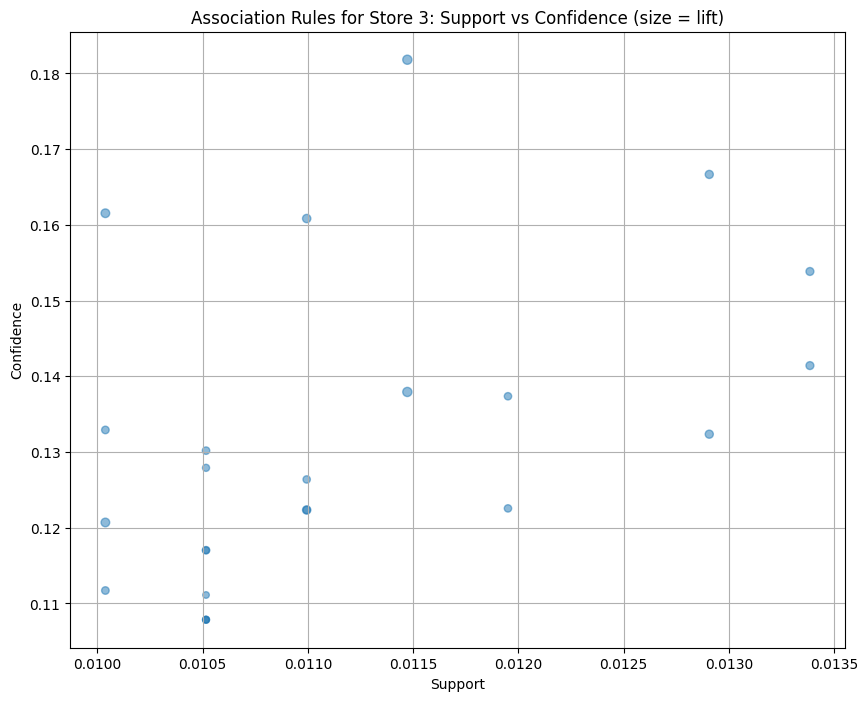


Top 10 Association Rules for Store 4:
  If customer buys They also buy   Support  Confidence      Lift
0     Product P117  Product P132  0.011616    0.147651  1.694855
1     Product P132  Product P117  0.011616    0.133333  1.694855
4     Product P115  Product P147  0.010560    0.142857  1.563997
5     Product P147  Product P115  0.010560    0.115607  1.563997
2     Product P144  Product P147  0.011088    0.128834  1.410476
3     Product P147  Product P144  0.011088    0.121387  1.410476
6     Product P117  Product P147  0.010032    0.127517  1.396051
7     Product P147  Product P117  0.010032    0.109827  1.396051
8     Product P144  Product P132  0.010032    0.116564  1.338018
9     Product P132  Product P144  0.010032    0.115152  1.338018


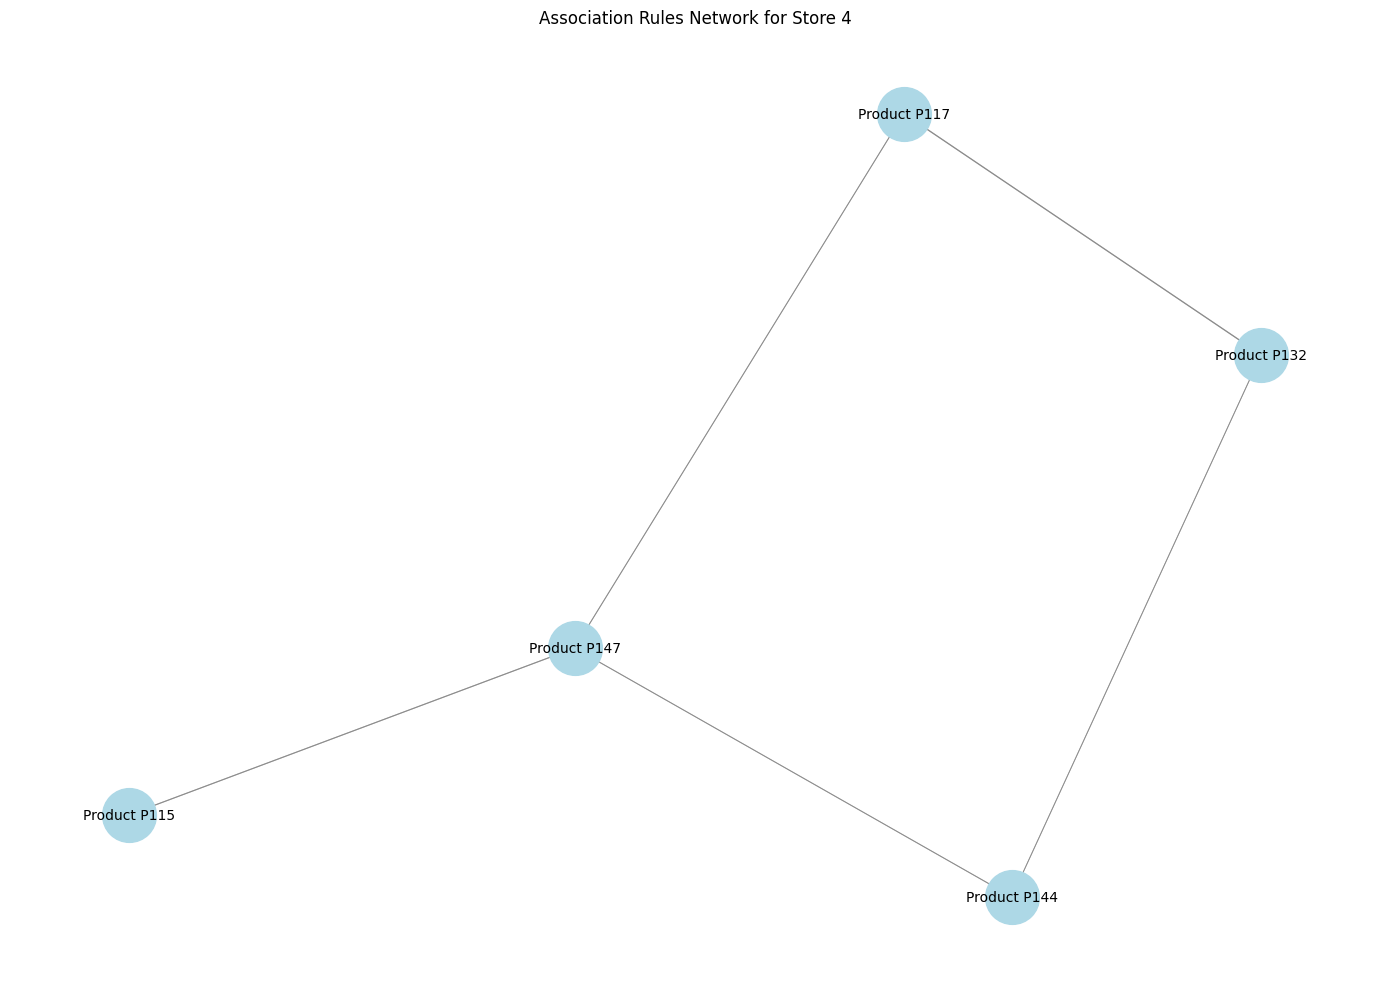

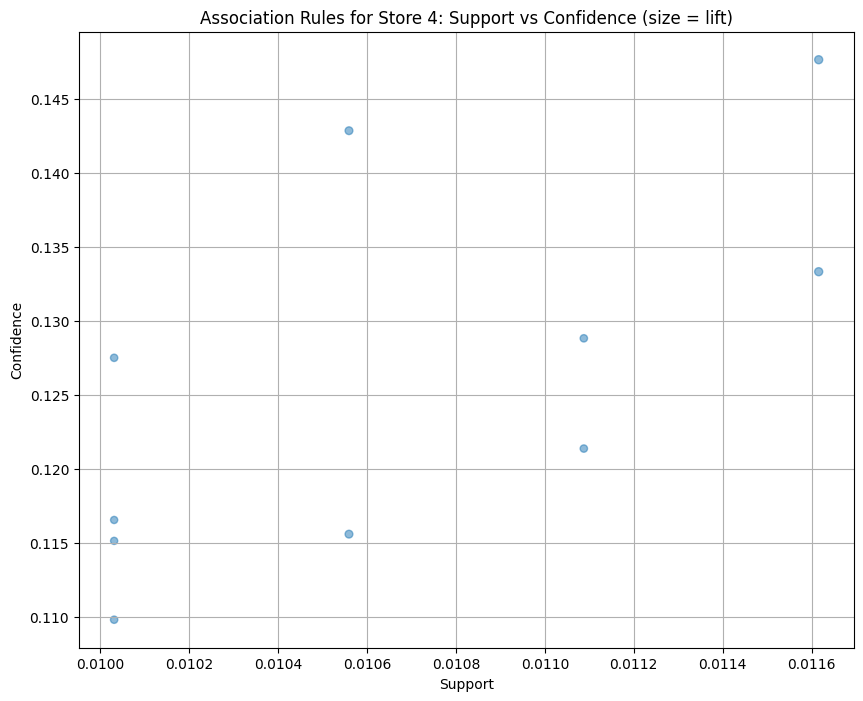


Top 10 Association Rules for Store 5:
   If customer buys They also buy   Support  Confidence      Lift
10     Product P105  Product P126  0.011068    0.132450  2.236801
11     Product P126  Product P105  0.011068    0.186916  2.236801
6      Product P138  Product P147  0.011621    0.176471  1.944405
7      Product P147  Product P138  0.011621    0.128049  1.944405
13     Product P115  Product P110  0.011068    0.152672  1.671987
12     Product P110  Product P115  0.011068    0.121212  1.671987
2      Product P108  Product P147  0.012728    0.144654  1.593841
3      Product P147  Product P108  0.012728    0.140244  1.593841
4      Product P132  Product P143  0.011621    0.115385  1.489286
5      Product P143  Product P132  0.011621    0.150000  1.489286


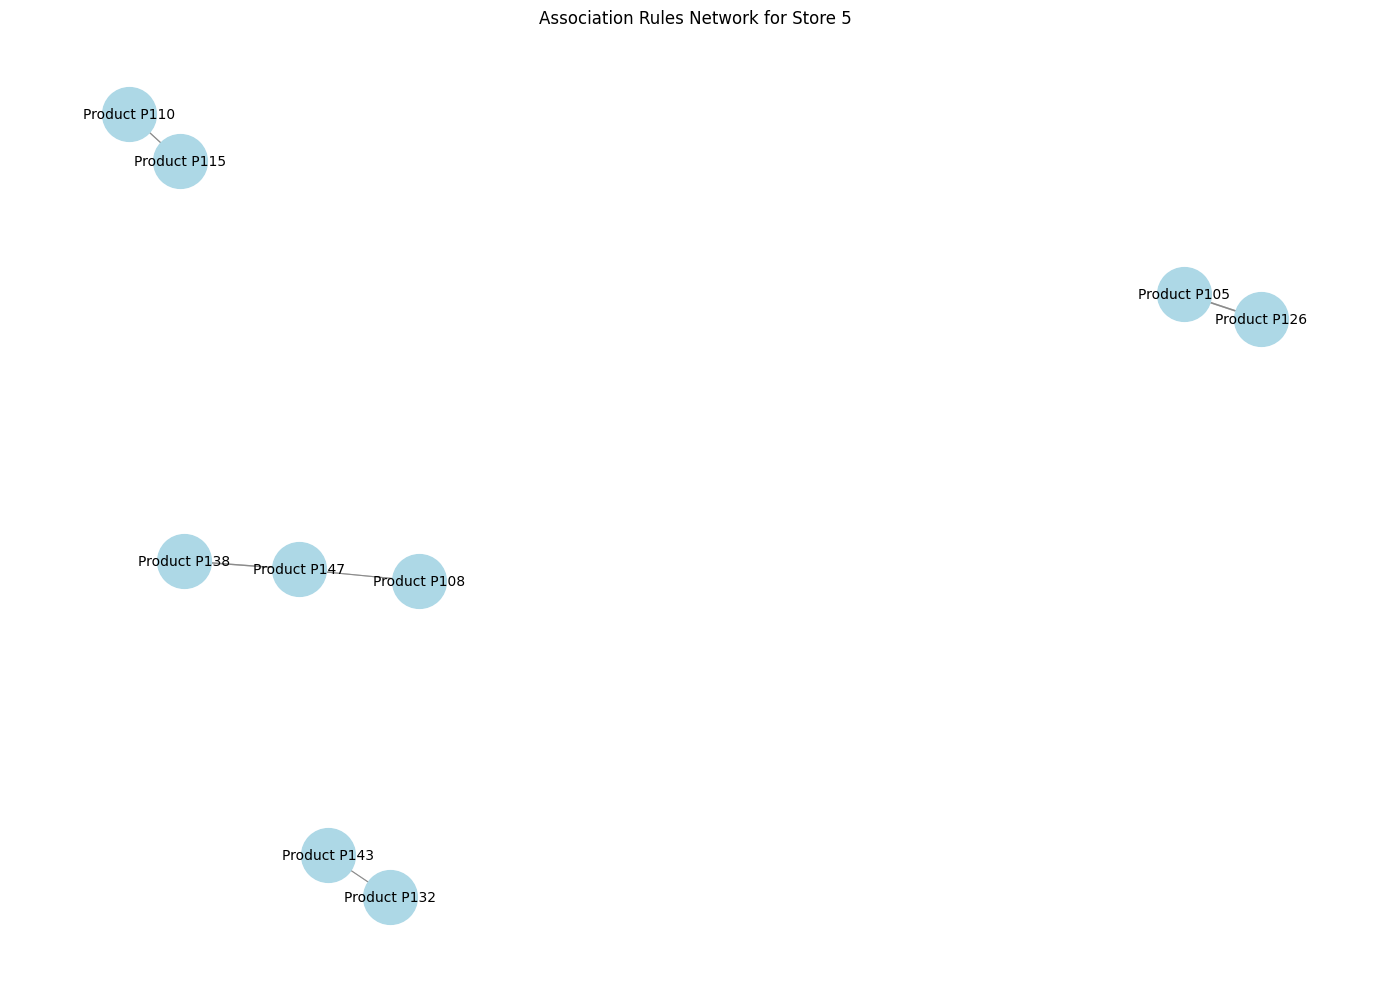

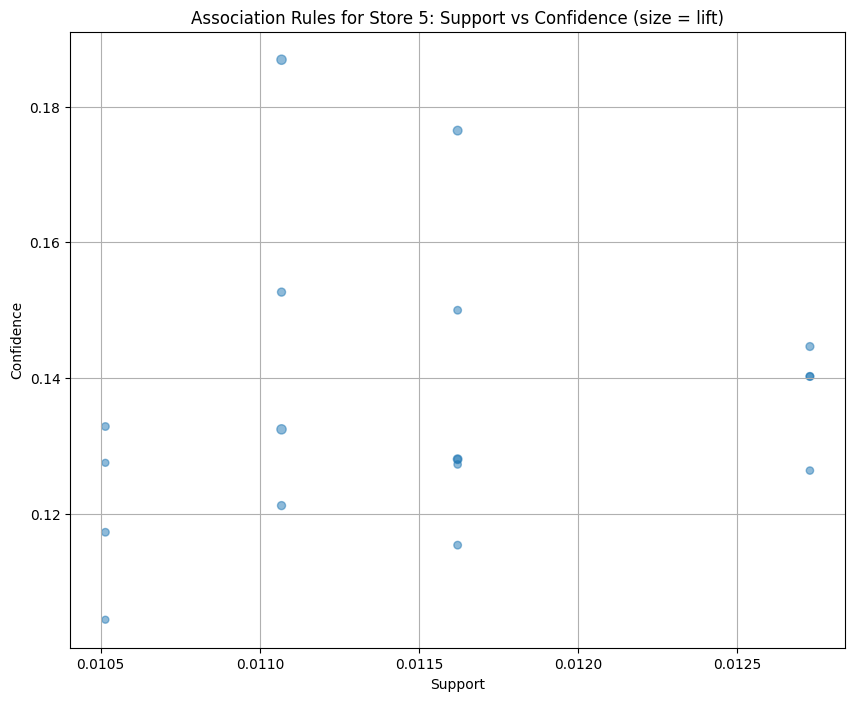


Top 10 Association Rules for Store 6:
   If customer buys They also buy   Support  Confidence      Lift
4      Product P117  Product P122  0.011443    0.145570  1.912385
5      Product P122  Product P117  0.011443    0.150327  1.912385
2      Product P117  Product P103  0.011443    0.145570  1.784115
3      Product P103  Product P117  0.011443    0.140244  1.784115
11     Product P105  Product P144  0.010448    0.134615  1.439239
10     Product P144  Product P105  0.010448    0.111702  1.439239
0      Product P144  Product P149  0.012935    0.138298  1.349411
1      Product P149  Product P144  0.012935    0.126214  1.349411
6      Product P103  Product P149  0.010945    0.134146  1.308904
7      Product P149  Product P103  0.010945    0.106796  1.308904


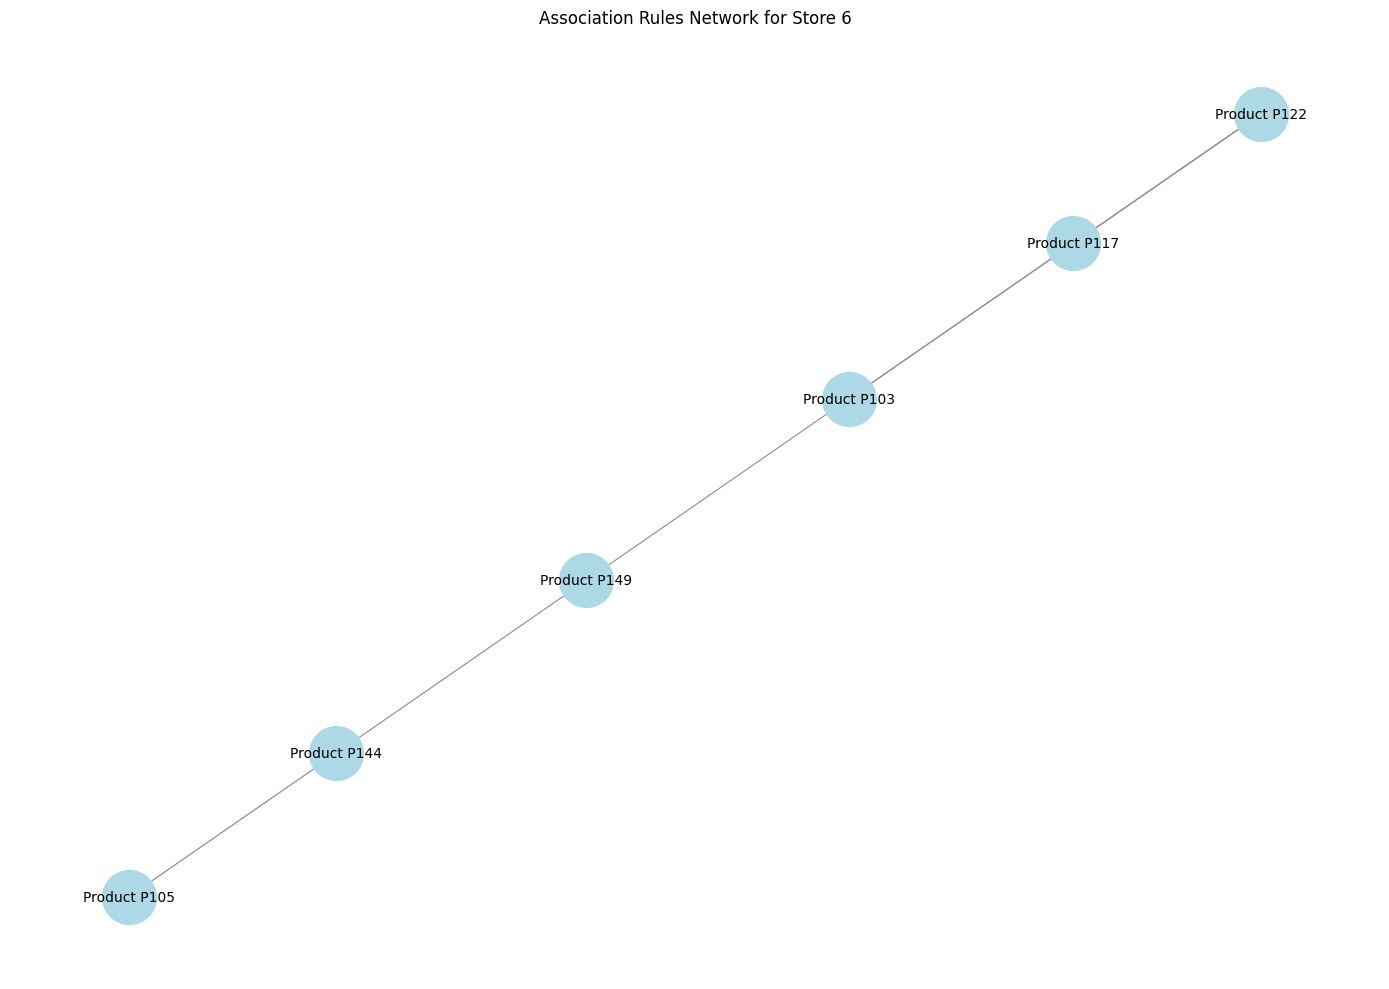

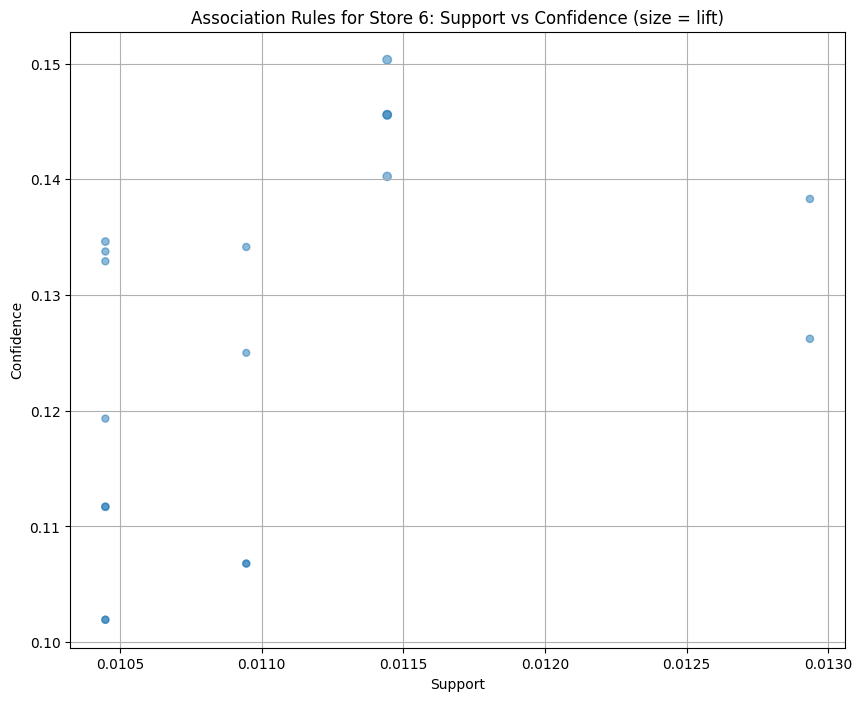


Top 10 Association Rules for Store 7:
   If customer buys They also buy   Support  Confidence      Lift
49     Product P119  Product P110  0.010056    0.178218  1.898868
48     Product P110  Product P119  0.010056    0.107143  1.898868
0      Product P110  Product P106  0.015084    0.160714  1.868043
1      Product P106  Product P110  0.015084    0.175325  1.868043
19     Product P130  Product P132  0.011732    0.170732  1.852180
18     Product P132  Product P130  0.011732    0.127273  1.852180
4      Product P105  Product P103  0.014525    0.149425  1.844629
5      Product P103  Product P105  0.014525    0.179310  1.844629
2      Product P117  Product P110  0.014525    0.172185  1.834595
3      Product P110  Product P117  0.014525    0.154762  1.834595


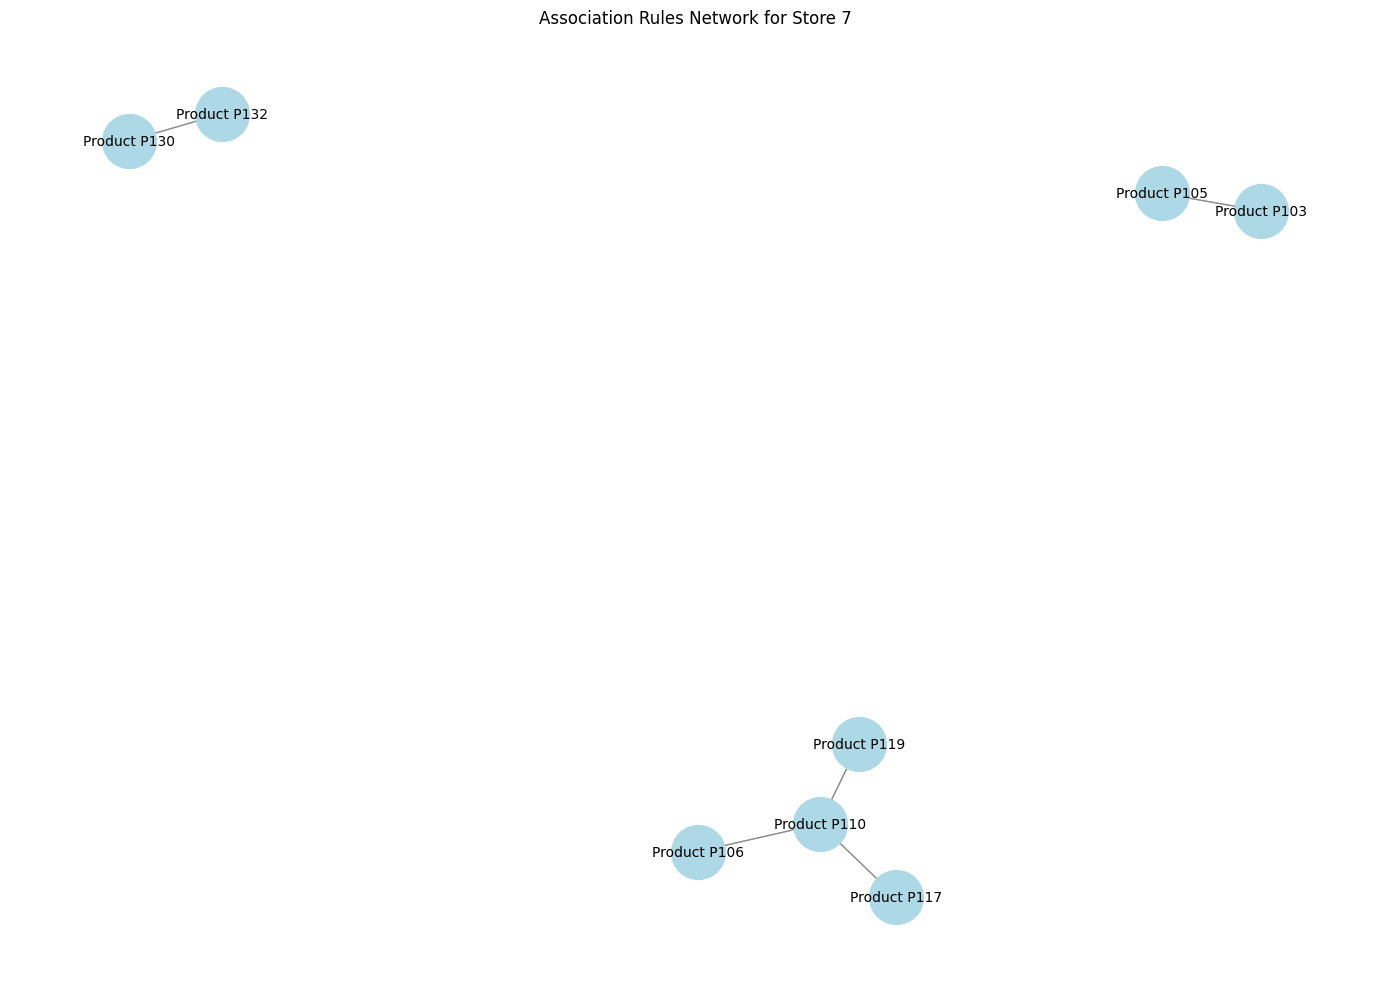

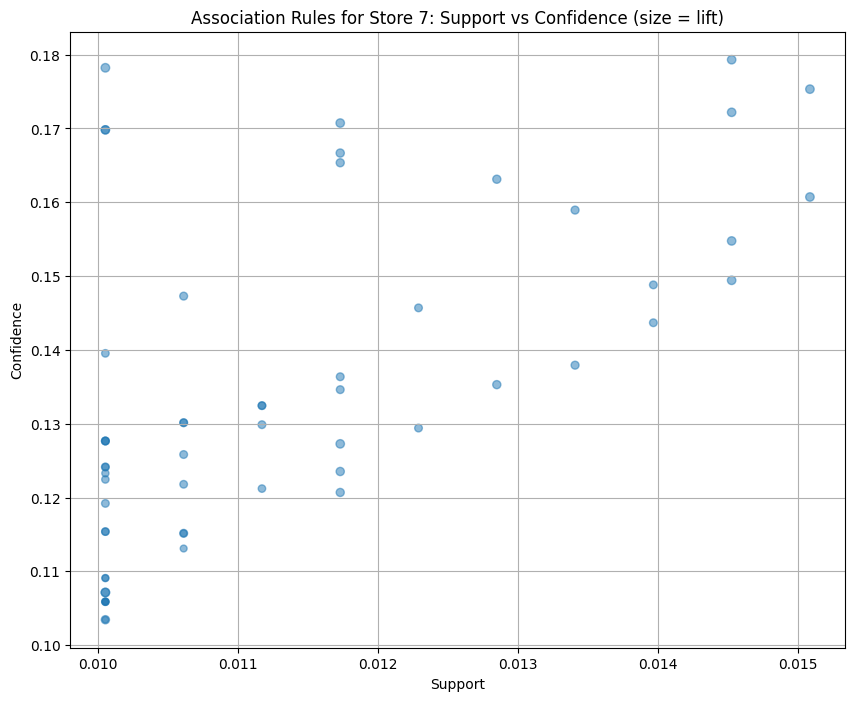


Top 10 Association Rules for Store 8:
   If customer buys They also buy   Support  Confidence      Lift
9      Product P141  Product P138  0.011820    0.156250  2.221639
8      Product P138  Product P141  0.011820    0.168067  2.221639
25     Product P104  Product P147  0.011229    0.197917  2.217715
24     Product P147  Product P104  0.011229    0.125828  2.217715
11     Product P144  Product P117  0.011820    0.137931  1.977791
10     Product P117  Product P144  0.011820    0.169492  1.977791
23     Product P130  Product P105  0.011229    0.172727  1.922727
22     Product P105  Product P130  0.011229    0.125000  1.922727
1      Product P103  Product P105  0.014184    0.172662  1.921999
0      Product P105  Product P103  0.014184    0.157895  1.921999


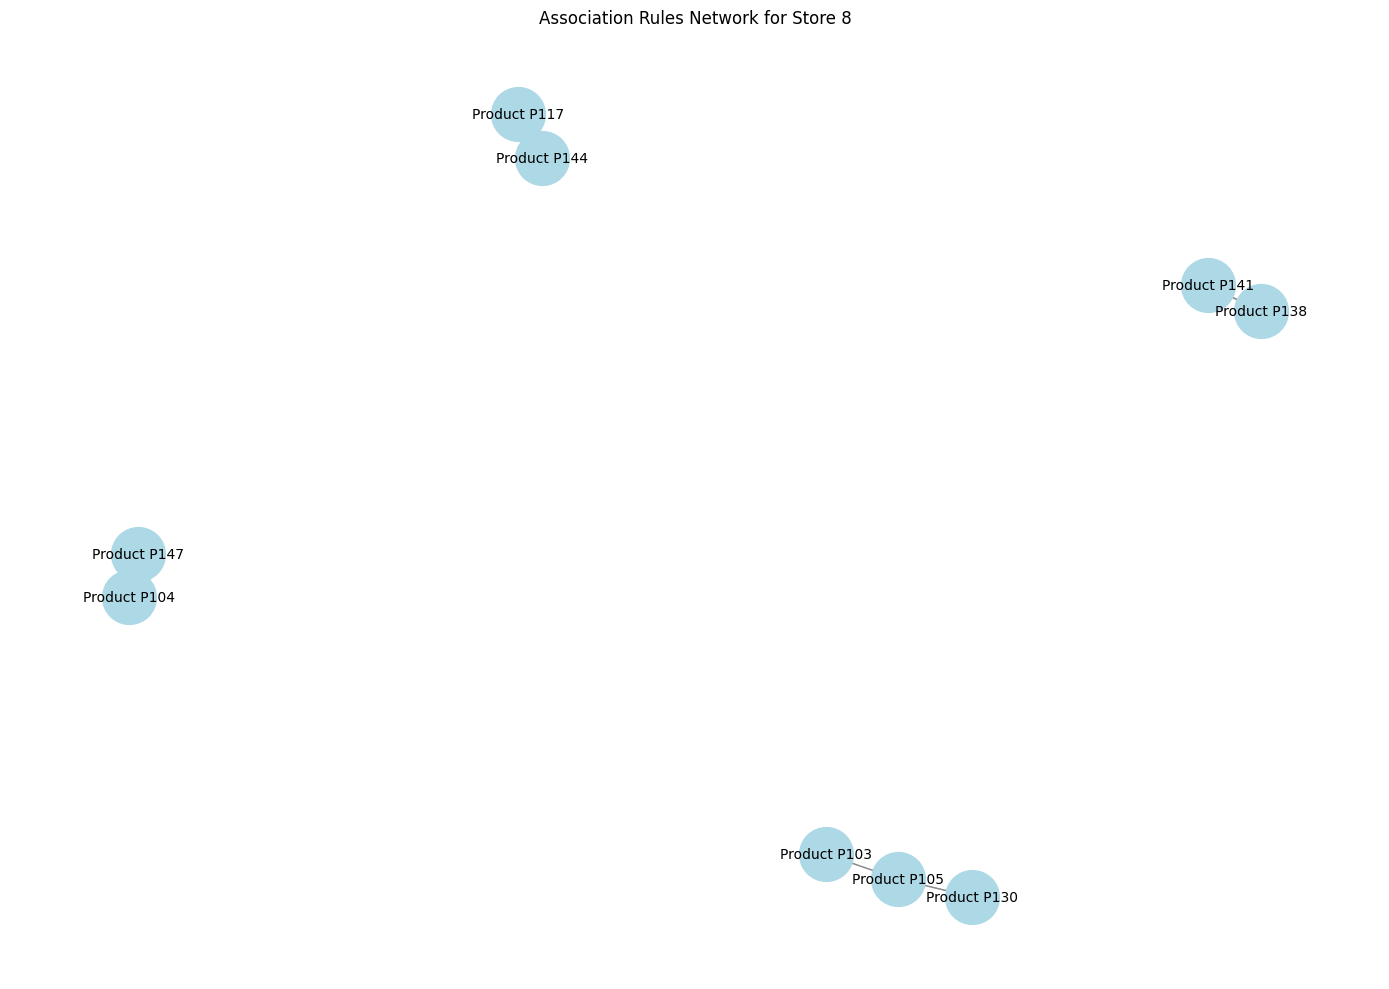

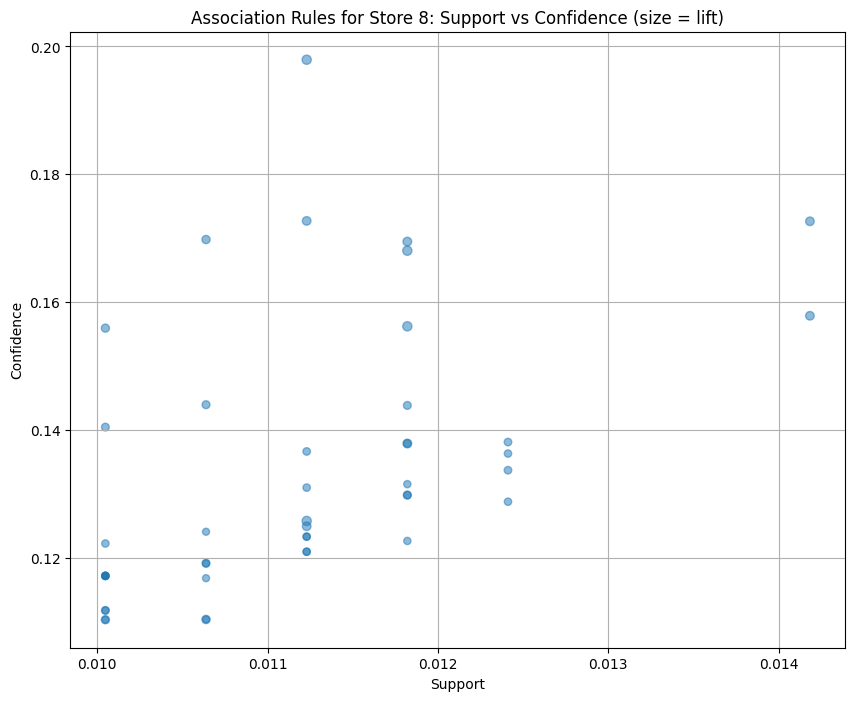

In [6]:
# Function to format itemsets for display
def format_itemset(itemset):
    return ', '.join(list(itemset))

# Function to visualize top rules for a store
def visualize_store_rules(store_id, top_n=10):
    rules = results[store_id]['rules']
    
    if rules.empty:
        print(f"No rules found for Store {store_id}")
        return
    
    # Add formatted columns for better readability
    rules['antecedents_str'] = rules['antecedents'].apply(format_itemset)
    rules['consequents_str'] = rules['consequents'].apply(format_itemset)
    
    # Display top rules
    top_rules = rules.head(top_n)[['antecedents_str', 'consequents_str', 'support', 'confidence', 'lift']]
    top_rules.columns = ['If customer buys', 'They also buy', 'Support', 'Confidence', 'Lift']
    
    print(f"\nTop {top_n} Association Rules for Store {store_id}:")
    print(top_rules)
    
    # Visualize network graph for top rules
    if len(rules) >= 5:
        top_rules_vis = rules.head(min(10, len(rules)))
        
        # Create network graph
        G = nx.DiGraph()
        
        # Add nodes and edges
        for _, row in top_rules_vis.iterrows():
            antecedent = format_itemset(row['antecedents'])
            consequent = format_itemset(row['consequents'])
            
            # Add nodes
            if antecedent not in G.nodes:
                G.add_node(antecedent)
            if consequent not in G.nodes:
                G.add_node(consequent)
            
            # Add edge with lift as weight
            G.add_edge(antecedent, consequent, weight=row['lift'], 
                      support=row['support'], confidence=row['confidence'])
        
        # Plot the network
        plt.figure(figsize=(14, 10))
        pos = nx.spring_layout(G, seed=42)
        
        # Draw nodes
        nx.draw_networkx_nodes(G, pos, node_size=1500, node_color='lightblue')
        
        # Draw edges with width based on lift
        edges = G.edges(data=True)
        edge_widths = [d['weight']/2 for u, v, d in edges]
        nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.7, 
                              edge_color='grey', arrows=True, arrowsize=20)
        
        # Draw labels
        nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')
        
        plt.axis('off')
        plt.title(f'Association Rules Network for Store {store_id}')
        plt.tight_layout()
        plt.show()
        
        # Scatter plot of rules
        plt.figure(figsize=(10, 8))
        plt.scatter(rules['support'], rules['confidence'], s=rules['lift']*20, alpha=0.5)
        plt.xlabel('Support')
        plt.ylabel('Confidence')
        plt.title(f'Association Rules for Store {store_id}: Support vs Confidence (size = lift)')
        plt.grid(True)
        plt.show()

# Visualize results for each store
for store_id in results.keys():
    visualize_store_rules(store_id)

## Cross-Store Comparison

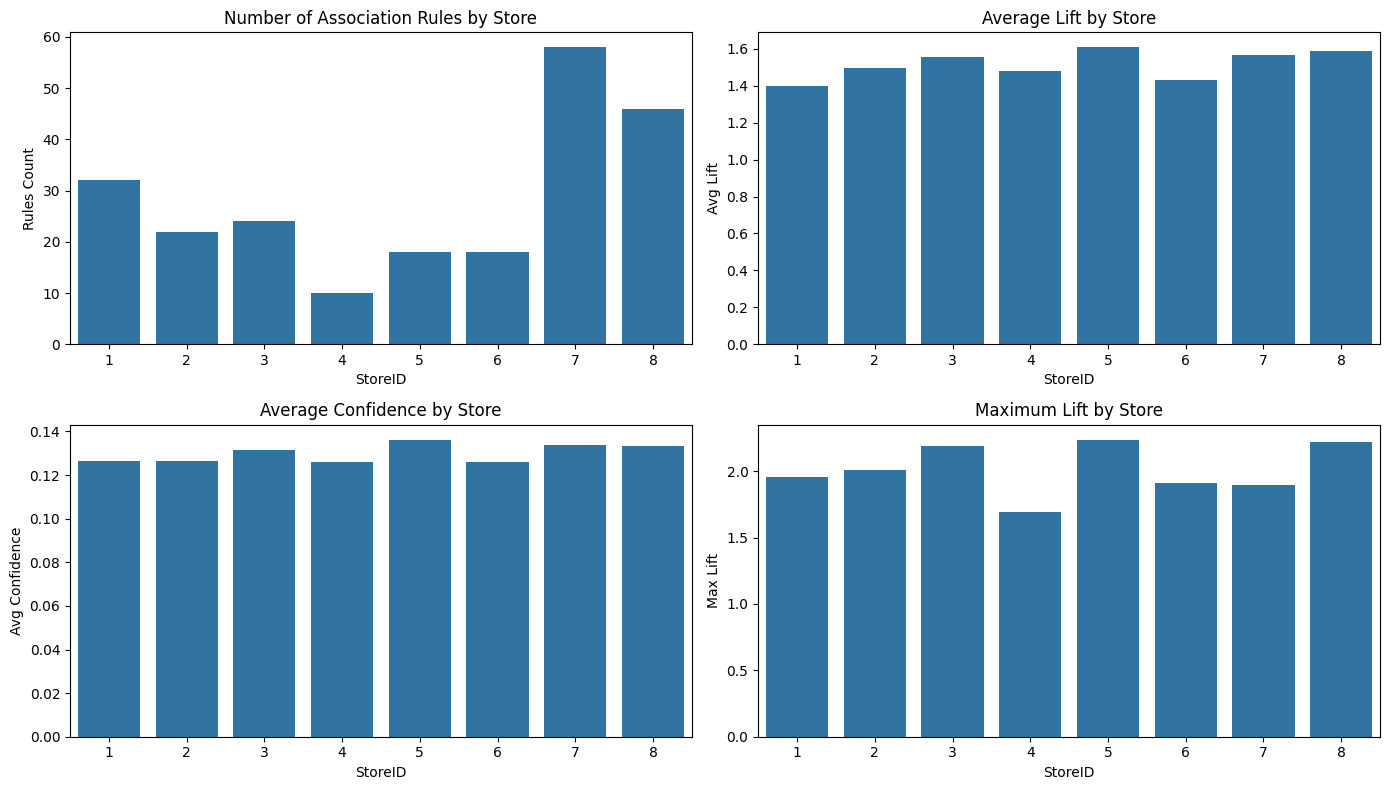


Store Comparison Metrics:
   StoreID  Rules Count  Avg Support  Avg Confidence  Avg Lift  Max Lift
0        1           32     0.011375        0.126280  1.396870  1.952184
1        2           22     0.010667        0.126422  1.495584  2.007305
2        3           24     0.011154        0.131643  1.553847  2.185998
3        4           10     0.010665        0.125873  1.480679  1.694855
4        5           18     0.011498        0.136225  1.608797  2.236801
5        6           18     0.011056        0.125936  1.432375  1.912385
6        7           58     0.011347        0.133821  1.566918  1.898868
7        8           46     0.011178        0.133408  1.587454  2.221639


In [7]:
# Compare performance metrics across stores
def compare_stores():
    comparison_data = []
    
    for store_id, data in results.items():
        rules = data['rules']
        if not rules.empty:
            avg_support = rules['support'].mean()
            avg_confidence = rules['confidence'].mean()
            avg_lift = rules['lift'].mean()
            num_rules = len(rules)
            max_lift = rules['lift'].max()
            
            comparison_data.append({
                'StoreID': store_id,
                'Rules Count': num_rules,
                'Avg Support': avg_support,
                'Avg Confidence': avg_confidence,
                'Avg Lift': avg_lift,
                'Max Lift': max_lift
            })
    
    comparison_df = pd.DataFrame(comparison_data)
    
    if not comparison_df.empty:
        # Plot comparison
        plt.figure(figsize=(14, 8))
        
        # Rules count by store
        plt.subplot(2, 2, 1)
        sns.barplot(x='StoreID', y='Rules Count', data=comparison_df)
        plt.title('Number of Association Rules by Store')
        
        # Average lift by store
        plt.subplot(2, 2, 2)
        sns.barplot(x='StoreID', y='Avg Lift', data=comparison_df)
        plt.title('Average Lift by Store')
        
        # Average confidence by store
        plt.subplot(2, 2, 3)
        sns.barplot(x='StoreID', y='Avg Confidence', data=comparison_df)
        plt.title('Average Confidence by Store')
        
        # Max lift by store
        plt.subplot(2, 2, 4)
        sns.barplot(x='StoreID', y='Max Lift', data=comparison_df)
        plt.title('Maximum Lift by Store')
        
        plt.tight_layout()
        plt.show()
        
        return comparison_df
    else:
        print("No comparison data available")
        return pd.DataFrame()

# Run comparison
store_comparison = compare_stores()
print("\nStore Comparison Metrics:")
print(store_comparison)

## Generate Business Insights

In [8]:
from IPython.display import display, Markdown

# Function to generate insights for a store
def generate_store_insights(store_id):
    rules = results[store_id]['rules']
    
    if rules.empty:
        return f"No significant patterns found for Store {store_id}"
    
    # Top 3 rules by lift
    top_rules = rules.head(3)
    
    insights = f"""
## Business Insights for Store {store_id}

### Top Association Rules:
"""
    
    for i, (_, rule) in enumerate(top_rules.iterrows()):
        antecedent = format_itemset(rule['antecedents'])
        consequent = format_itemset(rule['consequents'])
        
        insights += f"""
{i+1}. If customers buy **{antecedent}**, they are {rule['lift']:.2f} times more likely to buy **{consequent}**
   - Support: {rule['support']:.2%} (appears in {rule['support']:.2%} of transactions)
   - Confidence: {rule['confidence']:.2%} ({rule['confidence']:.2%} of baskets with {antecedent} also contain {consequent})
"""
    
    insights += f"""
### Recommendations:
1. **Product Placement**: Place {format_itemset(top_rules.iloc[0]['antecedents'])} near {format_itemset(top_rules.iloc[0]['consequents'])}
2. **Bundling Opportunity**: Create a bundle of {format_itemset(top_rules.iloc[0]['antecedents'])} with {format_itemset(top_rules.iloc[0]['consequents'])}
3. **Cross-Selling**: Train staff to suggest {format_itemset(top_rules.iloc[1]['consequents'])} when customers purchase {format_itemset(top_rules.iloc[1]['antecedents'])}
"""
    
    return insights

# Generate insights for all stores
for store_id in results.keys():
    insights = generate_store_insights(store_id)
    display(Markdown(insights))


## Business Insights for Store 1

### Top Association Rules:

1. If customers buy **Product P144**, they are 1.95 times more likely to buy **Product P103**
   - Support: 1.42% (appears in 1.42% of transactions)
   - Confidence: 14.67% (14.67% of baskets with Product P144 also contain Product P103)

2. If customers buy **Product P103**, they are 1.95 times more likely to buy **Product P144**
   - Support: 1.42% (appears in 1.42% of transactions)
   - Confidence: 18.97% (18.97% of baskets with Product P103 also contain Product P144)

3. If customers buy **Product P108**, they are 1.77 times more likely to buy **Product P144**
   - Support: 1.42% (appears in 1.42% of transactions)
   - Confidence: 17.19% (17.19% of baskets with Product P108 also contain Product P144)

### Recommendations:
1. **Product Placement**: Place Product P144 near Product P103
2. **Bundling Opportunity**: Create a bundle of Product P144 with Product P103
3. **Cross-Selling**: Train staff to suggest Product P144 when customers purchase Product P103



## Business Insights for Store 2

### Top Association Rules:

1. If customers buy **Product P125**, they are 2.01 times more likely to buy **Product P149**
   - Support: 1.06% (appears in 1.06% of transactions)
   - Confidence: 17.27% (17.27% of baskets with Product P125 also contain Product P149)

2. If customers buy **Product P149**, they are 2.01 times more likely to buy **Product P125**
   - Support: 1.06% (appears in 1.06% of transactions)
   - Confidence: 12.31% (12.31% of baskets with Product P149 also contain Product P125)

3. If customers buy **Product P106**, they are 1.89 times more likely to buy **Product P115**
   - Support: 1.01% (appears in 1.01% of transactions)
   - Confidence: 11.33% (11.33% of baskets with Product P106 also contain Product P115)

### Recommendations:
1. **Product Placement**: Place Product P125 near Product P149
2. **Bundling Opportunity**: Create a bundle of Product P125 with Product P149
3. **Cross-Selling**: Train staff to suggest Product P125 when customers purchase Product P149



## Business Insights for Store 3

### Top Association Rules:

1. If customers buy **Product P138**, they are 2.19 times more likely to buy **Product P127**
   - Support: 1.15% (appears in 1.15% of transactions)
   - Confidence: 18.18% (18.18% of baskets with Product P138 also contain Product P127)

2. If customers buy **Product P127**, they are 2.19 times more likely to buy **Product P138**
   - Support: 1.15% (appears in 1.15% of transactions)
   - Confidence: 13.79% (13.79% of baskets with Product P127 also contain Product P138)

3. If customers buy **Product P119**, they are 1.94 times more likely to buy **Product P127**
   - Support: 1.00% (appears in 1.00% of transactions)
   - Confidence: 16.15% (16.15% of baskets with Product P119 also contain Product P127)

### Recommendations:
1. **Product Placement**: Place Product P138 near Product P127
2. **Bundling Opportunity**: Create a bundle of Product P138 with Product P127
3. **Cross-Selling**: Train staff to suggest Product P138 when customers purchase Product P127



## Business Insights for Store 4

### Top Association Rules:

1. If customers buy **Product P117**, they are 1.69 times more likely to buy **Product P132**
   - Support: 1.16% (appears in 1.16% of transactions)
   - Confidence: 14.77% (14.77% of baskets with Product P117 also contain Product P132)

2. If customers buy **Product P132**, they are 1.69 times more likely to buy **Product P117**
   - Support: 1.16% (appears in 1.16% of transactions)
   - Confidence: 13.33% (13.33% of baskets with Product P132 also contain Product P117)

3. If customers buy **Product P115**, they are 1.56 times more likely to buy **Product P147**
   - Support: 1.06% (appears in 1.06% of transactions)
   - Confidence: 14.29% (14.29% of baskets with Product P115 also contain Product P147)

### Recommendations:
1. **Product Placement**: Place Product P117 near Product P132
2. **Bundling Opportunity**: Create a bundle of Product P117 with Product P132
3. **Cross-Selling**: Train staff to suggest Product P117 when customers purchase Product P132



## Business Insights for Store 5

### Top Association Rules:

1. If customers buy **Product P105**, they are 2.24 times more likely to buy **Product P126**
   - Support: 1.11% (appears in 1.11% of transactions)
   - Confidence: 13.25% (13.25% of baskets with Product P105 also contain Product P126)

2. If customers buy **Product P126**, they are 2.24 times more likely to buy **Product P105**
   - Support: 1.11% (appears in 1.11% of transactions)
   - Confidence: 18.69% (18.69% of baskets with Product P126 also contain Product P105)

3. If customers buy **Product P138**, they are 1.94 times more likely to buy **Product P147**
   - Support: 1.16% (appears in 1.16% of transactions)
   - Confidence: 17.65% (17.65% of baskets with Product P138 also contain Product P147)

### Recommendations:
1. **Product Placement**: Place Product P105 near Product P126
2. **Bundling Opportunity**: Create a bundle of Product P105 with Product P126
3. **Cross-Selling**: Train staff to suggest Product P105 when customers purchase Product P126



## Business Insights for Store 6

### Top Association Rules:

1. If customers buy **Product P117**, they are 1.91 times more likely to buy **Product P122**
   - Support: 1.14% (appears in 1.14% of transactions)
   - Confidence: 14.56% (14.56% of baskets with Product P117 also contain Product P122)

2. If customers buy **Product P122**, they are 1.91 times more likely to buy **Product P117**
   - Support: 1.14% (appears in 1.14% of transactions)
   - Confidence: 15.03% (15.03% of baskets with Product P122 also contain Product P117)

3. If customers buy **Product P117**, they are 1.78 times more likely to buy **Product P103**
   - Support: 1.14% (appears in 1.14% of transactions)
   - Confidence: 14.56% (14.56% of baskets with Product P117 also contain Product P103)

### Recommendations:
1. **Product Placement**: Place Product P117 near Product P122
2. **Bundling Opportunity**: Create a bundle of Product P117 with Product P122
3. **Cross-Selling**: Train staff to suggest Product P117 when customers purchase Product P122



## Business Insights for Store 7

### Top Association Rules:

1. If customers buy **Product P119**, they are 1.90 times more likely to buy **Product P110**
   - Support: 1.01% (appears in 1.01% of transactions)
   - Confidence: 17.82% (17.82% of baskets with Product P119 also contain Product P110)

2. If customers buy **Product P110**, they are 1.90 times more likely to buy **Product P119**
   - Support: 1.01% (appears in 1.01% of transactions)
   - Confidence: 10.71% (10.71% of baskets with Product P110 also contain Product P119)

3. If customers buy **Product P110**, they are 1.87 times more likely to buy **Product P106**
   - Support: 1.51% (appears in 1.51% of transactions)
   - Confidence: 16.07% (16.07% of baskets with Product P110 also contain Product P106)

### Recommendations:
1. **Product Placement**: Place Product P119 near Product P110
2. **Bundling Opportunity**: Create a bundle of Product P119 with Product P110
3. **Cross-Selling**: Train staff to suggest Product P119 when customers purchase Product P110



## Business Insights for Store 8

### Top Association Rules:

1. If customers buy **Product P141**, they are 2.22 times more likely to buy **Product P138**
   - Support: 1.18% (appears in 1.18% of transactions)
   - Confidence: 15.62% (15.62% of baskets with Product P141 also contain Product P138)

2. If customers buy **Product P138**, they are 2.22 times more likely to buy **Product P141**
   - Support: 1.18% (appears in 1.18% of transactions)
   - Confidence: 16.81% (16.81% of baskets with Product P138 also contain Product P141)

3. If customers buy **Product P104**, they are 2.22 times more likely to buy **Product P147**
   - Support: 1.12% (appears in 1.12% of transactions)
   - Confidence: 19.79% (19.79% of baskets with Product P104 also contain Product P147)

### Recommendations:
1. **Product Placement**: Place Product P141 near Product P138
2. **Bundling Opportunity**: Create a bundle of Product P141 with Product P138
3. **Cross-Selling**: Train staff to suggest Product P141 when customers purchase Product P138


## Category-Based Analysis


Top Category Association Rules:
  If customer buys from    They also buy from   Support  Confidence      Lift
0                 Books               Apparel  0.105922    0.248717  1.004180
1               Apparel                 Books  0.105922    0.427654  1.004180
2        Books, Grocery           Electronics  0.105260    0.642020  1.110060
3    Books, Electronics               Grocery  0.105260    0.458718  1.150301
4  Electronics, Grocery                 Books  0.105260    0.496407  1.165619
5                 Books  Electronics, Grocery  0.105260    0.247161  1.165619
6               Grocery    Books, Electronics  0.105260    0.263953  1.150301
7           Electronics        Books, Grocery  0.105260    0.181995  1.110060
8               Grocery               Apparel  0.100556    0.252159  1.018080
9               Apparel               Grocery  0.100556    0.405991  1.018080


C:\Users\Khor Kean Teng\AppData\Local\Temp\ipykernel_8588\886073228.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


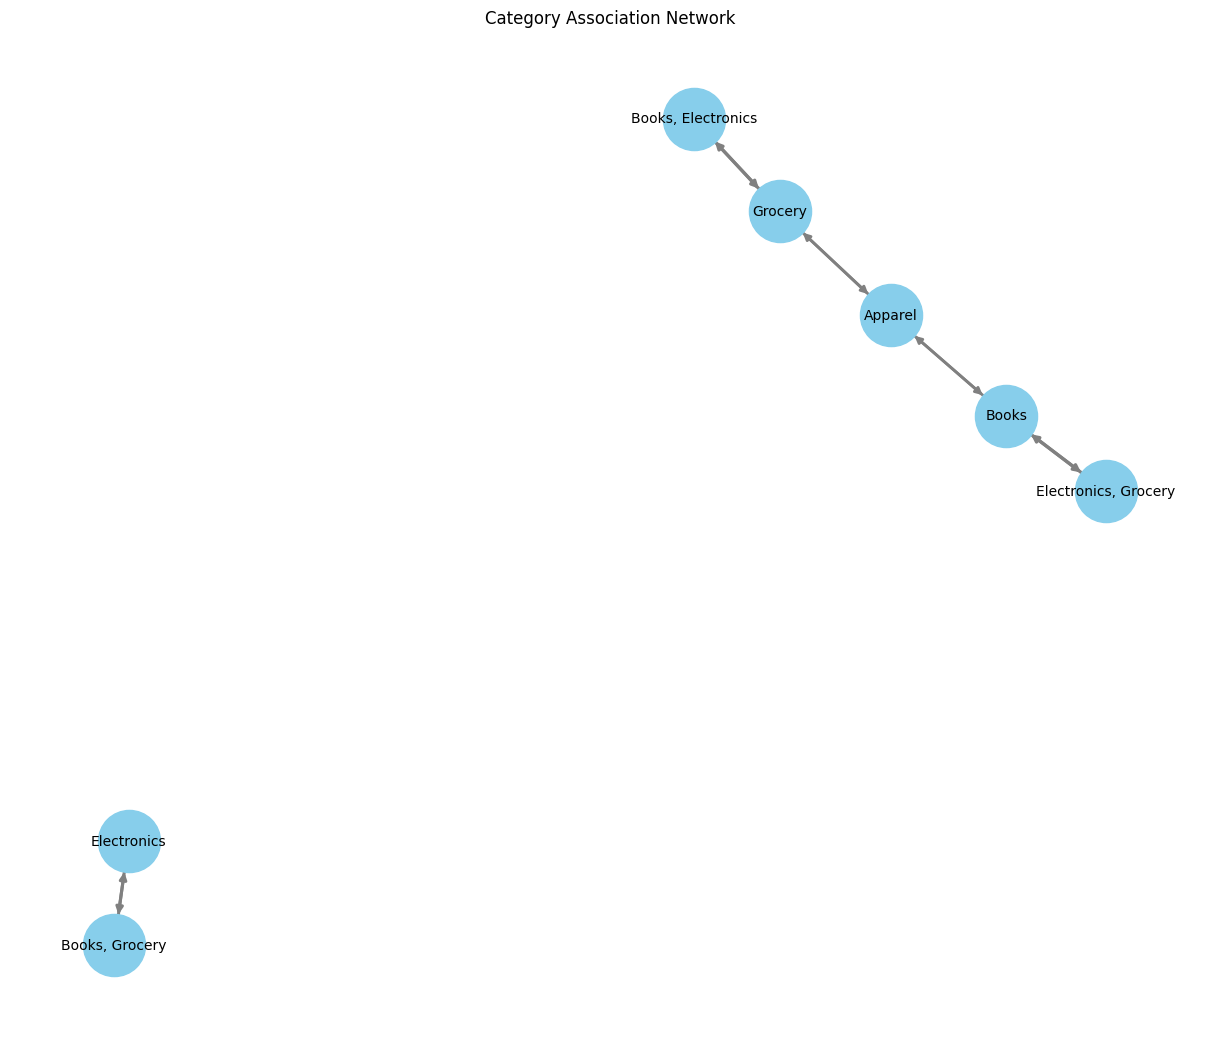

In [9]:
# Function to perform category-level market basket analysis
def category_level_analysis():
    # Create a list of transactions at category level
    category_transactions = df['ProductCategory'].tolist()
    
    # Encode the transactions
    te = TransactionEncoder()
    te_ary = te.fit(category_transactions).transform(category_transactions)
    category_df = pd.DataFrame(te_ary, columns=te.columns_)
    
    # Apply Apriori
    frequent_categories = apriori(category_df, min_support=0.02, use_colnames=True)
    
    if not frequent_categories.empty:
        frequent_categories['length'] = frequent_categories['itemsets'].apply(lambda x: len(x))
        frequent_categories = frequent_categories.sort_values('support', ascending=False)
        
        # Generate rules
        category_rules = association_rules(frequent_categories, metric="lift", min_threshold=1.0)
        
        if not category_rules.empty:
            # Format for display
            category_rules['antecedents_str'] = category_rules['antecedents'].apply(format_itemset)
            category_rules['consequents_str'] = category_rules['consequents'].apply(format_itemset)
            
            # Display top category rules
            top_cat_rules = category_rules.head(10)[['antecedents_str', 'consequents_str', 'support', 'confidence', 'lift']]
            top_cat_rules.columns = ['If customer buys from', 'They also buy from', 'Support', 'Confidence', 'Lift']
            
            print("\nTop Category Association Rules:")
            print(top_cat_rules)
            
            # Visualize category relationships
            plt.figure(figsize=(12, 10))
            
            # Create graph
            G = nx.DiGraph()
            
            # Add nodes and edges for top 10 rules
            for _, row in category_rules.head(10).iterrows():
                antecedent = format_itemset(row['antecedents'])
                consequent = format_itemset(row['consequents'])
                
                if antecedent not in G.nodes:
                    G.add_node(antecedent)
                if consequent not in G.nodes:
                    G.add_node(consequent)
                
                G.add_edge(antecedent, consequent, weight=row['lift'])
            
            # Draw graph
            pos = nx.spring_layout(G, seed=42)
            edges = G.edges(data=True)
            weights = [d['weight']*2 for _, _, d in edges]
            
            nx.draw(G, pos, with_labels=True, node_color='skyblue', 
                   node_size=2000, edge_color='gray', width=weights, 
                   edge_cmap=plt.cm.Blues, font_size=10)
            
            plt.title('Category Association Network')
            plt.axis('off')
            plt.tight_layout()
            plt.show()
            
            return category_rules
    
    print("No significant category associations found")
    return pd.DataFrame()

# Run category analysis
category_rules = category_level_analysis()

## Conclusion and Recommendations

In [10]:
# Generate overall recommendations
def generate_overall_recommendations():
    # Compare store performance
    if not store_comparison.empty:
        best_store = store_comparison.loc[store_comparison['Avg Lift'].idxmax()]['StoreID']
        worst_store = store_comparison.loc[store_comparison['Avg Lift'].idxmin()]['StoreID']
    else:
        best_store = "N/A"
        worst_store = "N/A"
    
    # Collect top rules across all stores
    all_top_rules = []
    for store_id, data in results.items():
        if not data['rules'].empty:
            top_rule = data['rules'].iloc[0]
            all_top_rules.append((store_id, top_rule))
    
    recommendations = f"""
## Overall Recommendations from Market Basket Analysis

### Store Performance:
- Store {best_store} shows the strongest product associations
- Store {worst_store} shows the weakest associations and may need merchandising adjustments

### Cross-Store Opportunities:
"""
    
    if all_top_rules:
        recommendations += "#### Top product associations by store:\n"
        for store_id, rule in all_top_rules:
            antecedent = format_itemset(rule['antecedents'])
            consequent = format_itemset(rule['consequents'])
            recommendations += f"- Store {store_id}: {antecedent} → {consequent} (Lift: {rule['lift']:.2f})\n"
    
    recommendations += """
### Implementation Strategy:
1. **Store Layout Optimization**:
   - Reorganize product placements based on discovered associations
   - Create "customer journey" paths that follow frequent purchase patterns

2. **Targeted Marketing Campaigns**:
   - Develop store-specific promotions based on unique association patterns
   - Create bundled offerings of frequently co-purchased items

3. **Inventory Management**:
   - Ensure complementary products are stocked together
   - Adjust inventory levels based on association strengths

4. **Staff Training**:
   - Educate staff on cross-selling opportunities specific to each store
   - Implement suggestive selling based on top association rules

5. **Further Analysis**:
   - Conduct temporal analysis to identify seasonal patterns
   - Segment customers and analyze basket patterns by segment
   - Implement A/B testing to validate recommendations
"""
    
    return recommendations

# Generate and print overall recommendations
overall_recommendations = generate_overall_recommendations()
display(Markdown(overall_recommendations))


## Overall Recommendations from Market Basket Analysis

### Store Performance:
- Store 5.0 shows the strongest product associations
- Store 1.0 shows the weakest associations and may need merchandising adjustments

### Cross-Store Opportunities:
#### Top product associations by store:
- Store 1: Product P144 → Product P103 (Lift: 1.95)
- Store 2: Product P125 → Product P149 (Lift: 2.01)
- Store 3: Product P138 → Product P127 (Lift: 2.19)
- Store 4: Product P117 → Product P132 (Lift: 1.69)
- Store 5: Product P105 → Product P126 (Lift: 2.24)
- Store 6: Product P117 → Product P122 (Lift: 1.91)
- Store 7: Product P119 → Product P110 (Lift: 1.90)
- Store 8: Product P141 → Product P138 (Lift: 2.22)

### Implementation Strategy:
1. **Store Layout Optimization**:
   - Reorganize product placements based on discovered associations
   - Create "customer journey" paths that follow frequent purchase patterns

2. **Targeted Marketing Campaigns**:
   - Develop store-specific promotions based on unique association patterns
   - Create bundled offerings of frequently co-purchased items

3. **Inventory Management**:
   - Ensure complementary products are stocked together
   - Adjust inventory levels based on association strengths

4. **Staff Training**:
   - Educate staff on cross-selling opportunities specific to each store
   - Implement suggestive selling based on top association rules

5. **Further Analysis**:
   - Conduct temporal analysis to identify seasonal patterns
   - Segment customers and analyze basket patterns by segment
   - Implement A/B testing to validate recommendations
